In [9]:
%matplotlib inline
import json
import urllib2
import os
from tables import open_file
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from alleninf.api import get_probes_from_genes
from alleninf.data import get_values_at_locations
from alleninf.api import get_mni_coordinates_from_wells#
from alleninf.analysis import fixed_effects, approximate_random_effects, bayesian_random_effects

pd.options.display.max_rows = 2000
pd.options.display.max_columns = 999

api_url   = "http://api.brain-map.org/api/v2/data/query.json"
ahba_dir  = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/JULY29/AHBA'


In [10]:
down_regulated_genes = { # Clardy et al. (2006). Acute and chronic effects of developmental iron deficiency 
                         # on mRNA expression patterns in the brain. Journal of Neural Transmission, 71, 173–96. 
                         # http://www.ncbi.nlm.nih.gov/pubmed/17447428
                    'THRSP'      :  'thyroid hormone responsive protein',
                    #''          :  'Rattus norvegicus Nclone10 mRNA',
                    'TF'         :  'transferrin',
                    'MAL'        :  'mal, T-cell differentiation protein',
                    'KLK6'       :  'kallikrein-related peptidase 6', 
                    'HOMER1'     :  'homer homolog 1 (Drosophila), neuronal immediate early gene',
                    'MOBP'       :  'myelin-associated oligodendrocytic basic protein',
                    'APOD'       :  'apolipoprotein D',
                    #''          :  'Rat troponin-c mRNA'
                    'MOG'        :  'myelin oligodendrocyte glycoprotein',
                    'CRYAB'      :  'crystallin, alpha B',
                    #'Af6'       :  'afadin',
                    #''           :  'Rattus norvegicus retroviral-like ovarian specific transcript 30-1 mRNA',
                    'APOC1'      :  'apolipoprotein C-I',
                    'CA2'        :  'carbonic anhydrase II',
                    'RASGRP1'    :  'RAS guanyl releasing protein 1',
                    'STMN4'      :  'stathmin-like 4',
                    #'Rnf28'      :  'ring finger protein 28',
                    'LYZ'        :  'lysozyme', 
                    #'LOC309574' :  'olfactory receptor',
                    'GSTM1'      :  'glutathione S-transferase mu 1', 
                    'CTSS'       :  'cathepsin S', 
                    'DCK'        :  'deoxycytidine kinase',
                    #''           :  'Rattus norvegicus similar to S-100 protein, alpha chain (LOC295214), mRNA',
                    #''           :  'Rat PMSG-induced ovarian mRNA, 3’sequence, N1'
                       }

iron_homeostasis_gene_set = { # http://amp.pharm.mssm.edu/Harmonizome/gene_set/Iron+Homeostasis(Mus+musculus)/Wikipathways+Pathways
                    'FTH1': 'ferritin heavy polypeptide 1',
                    'FTL' : 'ferritin light polypeptide',
                    'HFE' :'hemochromatosis',
                    'HFE2' :'hemochromatosis type 2 (juvenile)',
                    'IL1A' :'interleukin 1, alpha',
                    'IL6' :'interleukin 6',
                    'IL6R' :'interleukin 6 receptor',
                    'IREB2':'iron-responsive element binding protein 2',
                    'SLC40A1':'solute carrier family 40 (iron-regulated transporter), member 1',
                    'TF':'transferrin',
                    'TFR2':'transferrin receptor 2',
                    'TNF' : 'tumor necrosis factor',
}


DA_metabolism_gene_set = { # http://amp.pharm.mssm.edu/Harmonizome/gene_set/Dopamine+metabolism(Homo+sapiens)/Wikipathways+Pathways
                    'COMT': 'catechol-O-methyltransferase',
                    'DDC': 'dopa decarboxylase (aromatic L-amino acid decarboxylase)',
                    'MAOA': 'monoamine oxidase A',
                    'MAOB': 'monoamine oxidase B',
                    'NQO1': 'NAD(P)H dehydrogenase, quinone 1',
                    'PPP2CA': 'protein phosphatase 2, catalytic subunit, alpha isozyme',
                    'PPP2CB': 'protein phosphatase 2, catalytic subunit, beta isozyme',
                    'PRKACA': 'protein kinase, cAMP-dependent, catalytic, alpha',
                    'PRKACB': 'protein kinase, cAMP-dependent, catalytic, beta',
                    'PRKACG': 'protein kinase, cAMP-dependent, catalytic, gamma',
                    #'SOD1': 'superoxide dismutase 1, soluble',
                    'TH': 'tyrosine hydroxylase',
                    'TYR': 'tyrosinase ',
                }

glu_metabolism_gene_set =  { #http://software.broadinstitute.org/gsea/msigdb/cards/REACTOME_GLUTAMATE_NEUROTRANSMITTER_RELEASE_CYCLE
                'UNC13B' : 'unc-13 homolog B (C. elegans)',
                'RIMS1' : 'regulating synaptic membrane exocytosis 1',
                'GLS2' : 'glutaminase 2 (liver, mitochondrial)',
                'GLS' : 'glutaminase',
                'SLC38A2' : 'solute carrier family 38, member 2',
                'SLC17A7' : 'solute carrier family 17 (sodium-dependent in...',
                'RAB3A' : 'RAB3A, member RAS oncogene family',
                'SLC1A1' : 'solute carrier family 1 (neuronal/epithelial ...',
                'SLC1A6' : 'solute carrier family 1 (high affinity aspart...',
                'SLC1A7' : 'solute carrier family 1 (glutamate transporte...',
                'SNAP25' : 'synaptosomal-associated protein, 25kDa',
                'STX1A' : 'syntaxin 1A (brain)',
                'STXBP1' : 'syntaxin binding protein 1',
                'VAMP2' : 'vesicle-associated membrane protein 2 (synapt...',
                'SYT1' : 'synaptotagmin I'}

gaba_metabolism_gene_set =  { #http://software.broadinstitute.org/gsea/msigdb/cards/BIOCARTA_GABA_PATHWAY
                'GPHN': 'gephyrin',
                'GABARAP': 'GABA(A) receptor-associated protein',
                'DNM1': 'dynamin 1',
                'GABRA1': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA2': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA3': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA4': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA5': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA6': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'SRC': 'v-src sarcoma (Schmidt-Ruppin A-2) viral onco...'
                }

astrocyte_neuron_metabolic_gene_set = [ # de Leeuw, C.,etal (2015). Involvement of astrocyte metabolic coupling 
                                        # in Tourette syndrome pathogenesis. European Journal of Human Genetics, 
                                        # 23(August 2014), 1–4. https://doi.org/10.1038/ejhg.2015.22
                                       'ME1', 'ALDH5A1', 'GBE1', 'GALM', 'PYGL', 'CPS1','PFKFB3', 
                                       'PYGB', 'IDH2', 'ENO1','PPP1R1A', 'MDH2', 'CS','PYGM', 'PGM3',
                                       'PHKG1', 'SLC3A2', 'PFKFB4', 'KHK','LDHB', 'PCK2','SLC2A8', 
                                       'PGM2', 'GPT','AKR1B1', 'NANS', 'PDK4','OGDHL','DHTKD1', 
                                       'PFKM', 'PGM1', 'PC','AGL'
                                      ]

glu_synpase_gene_set = [ # Lennington, et.al (2016). Transcriptome Analysis of the Human Striatum in Tourette Syndrome. 
                        # Biological Psychiatry, 79(5), 372–382. https://doi.org/10.1016/j.biopsych.2014.07.018# 
                        # Tuquoise module Glutamatergic synapse - Homo sapiens (human)
                        'PPP3R1', 'GRIA2', 'GNAO1', 'GRIA1', 'GRIK5', 'GLUL', 'GLS', 'DLG4', 'CACNA1A', 
                        'CACNA1D', 'SHANK2', 'DLGAP1', 'GRM8', 'GRIA3', 'HOMER1', 'GRM5', 'GRIN1', 'GRM7', 
                        'GRM1', 'MAPK1', 'PLCB1', 'SLC38A1', 'GNB5', 'PRKCB', 'GNB1', 'PRKCG', 'GRM4', 'ITPR1', 
                        'SHANK3', 'PPP3CB', 'ADCY5', 'ADCY1', 'ADCY3', 'GRIK4', 'ADCY9', 'GNG7', 'GNG4', 'GRIN2A', 
                        'PRKACA', 'GNG3', 'PPP3CA', 'SLC1A6', 'GLS2'
                       ]

hse_gene_set = ['BEND5', 'C1QL2', 'CACNA1E', 'COL24A1', 'COL6A1', 'CRYM', 'KCNC3', 'KCNH4', 'LGALS1', 
                'MFGE8', 'NEFH', 'PRSS12', 'SCN3B', 'SCN4B', 'SNCG', 'SV2C', 'SYT2', 'TPBG', 'VAMP1']


In [11]:
def return_probe_expression(gene_probes_dict, geneset_name):
    
    dfs   = []
    genes = gene_probes_dict.keys()
    
    if not os.path.isfile(os.path.join(ahba_dir, 'AHBA_%s.csv'%geneset_name)):
    
        print 'Fetching normalized gene expression values for:', genes
        print ''
        for gene in genes:
            probe_ids = ["'%s'" % probe_id for probe_id in gene_probes_dict[gene].keys()]
            print 'Probe IDs for Gene %s = %s' % (gene, probe_ids)

            api_query = api_url + "?criteria=service::human_microarray_expression[probes$in%s]" % (','.join(probe_ids))
            data = json.load(urllib2.urlopen(api_query))
            print api_query

            cols = ['top_struct','struct_name','struct_id', 'donor_names', 'coords_native']
            probe_cols = ['%s_'%gene + str(i) for i in gene_probes_dict[gene].values()]
            cols = cols + probe_cols
            well_ids = [str(sample["sample"]["well"]) for sample in data["msg"]["samples"]]
            df   = pd.DataFrame(index = well_ids, columns = cols)

            df['top_struct']     = [sample["top_level_structure"]["name"] for sample in data["msg"]["samples"]]
            df['struct_id']      = [sample["structure"]["id"] for sample in data["msg"]["samples"]]
            df['struct_name']    = [sample["structure"]["name"] for sample in data["msg"]["samples"]]
            df['donor_names']    = [sample["donor"]["name"]for sample in data["msg"]["samples"]]
            df['coords_native']  = [sample["sample"]["mri"] for sample in data["msg"]["samples"]]

            for i, probe_id in enumerate(gene_probes_dict[gene].values()):
                df['%s_%s'%(gene,probe_id)] = [float(expression_value) for expression_value in data["msg"]["probes"][i]["expression_level"]]

            dfs.append(df)

        # concat all probe expression dataframes
        df = pd.concat(dfs,axis =1).T.groupby(level=0).first().T

        # decompose probe expression values
        all_probes =  ['%s_'%gene + str(i) for gene in gene_probes_dict.keys() for i in gene_probes_dict[gene].values()]

        df['Mean'] = df[all_probes].mean(axis=1)
        df['Median'] = df[all_probes].median(axis=1)

        from sklearn.decomposition import TruncatedSVD
        pca = TruncatedSVD(n_components=1)
        pca.fit(np.array(np.asarray([df[probe] for probe in all_probes])))
        df['PCA'] = pca.components_[0,:]

        package_directory = '/Users/kanaan/SCR/Github/alleninf/alleninf'
        #package_directory = '/scr/malta1/Software/anaconda/envs/awesome/lib/python2.7/site-packages/alleninf'
        mni = pd.read_csv(os.path.join(package_directory, "data", "corrected_mni_coordinates.csv"), 
                            header=0, index_col=0)
        mni.index = mni.index.map(unicode) 
        df_concat = pd.concat([df,mni], axis = 1 ).to_csv(os.path.join(ahba_dir, 'AHBA_%s.csv'%geneset_name))
    
    return pd.read_csv(os.path.join(ahba_dir, 'AHBA_%s.csv'%geneset_name),index_col=0)


def get_expression_df(genes, geneset_name):
    gene_probes = {}
    for gene in genes:
        gene_probes[gene] = get_probes_from_genes(gene)
        
    df = return_probe_expression(gene_probes,geneset_name)
    return df 
    


# Iron Homeostasis-Geneset

In [12]:
df_iron = get_expression_df(iron_homeostasis_gene_set.keys(), 'iron_homeostasis')

Fetching normalized gene expression values for: ['TFR2', 'SLC40A1', 'HFE2', 'IL6R', 'IL6', 'TNF', 'TF', 'IL1A', 'FTH1', 'HFE', 'FTL', 'IREB2']

Probe IDs for Gene TFR2 = ["'1050833'", "'1050834'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1050833','1050834']
Probe IDs for Gene SLC40A1 = ["'1044074'", "'1044075'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1044074','1044075']
Probe IDs for Gene HFE2 = ["'1030891'", "'1030889'", "'1030890'", "'1034511'", "'1023305'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1030891','1030889','1030890','1034511','1023305']
Probe IDs for Gene IL6R = ["'1055070'", "'1055071'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1055070','1055071']
Probe IDs for Gene IL6 = ["'1055072'", "'1055073'"]
http://api.brain-map.org

# Iron-deficiency downregulated geneset (Clardy, 2006)

In [13]:
df_iron_down = get_expression_df(down_regulated_genes.keys(), 'iron_downreg')

Fetching normalized gene expression values for: ['STMN4', 'APOD', 'RASGRP1', 'DCK', 'CA2', 'CRYAB', 'LYZ', 'TF', 'KLK6', 'APOC1', 'HOMER1', 'MOBP', 'CTSS', 'MOG', 'MAL', 'THRSP', 'GSTM1']

Probe IDs for Gene STMN4 = ["'1038344'", "'1038345'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1038344','1038345']
Probe IDs for Gene APOD = ["'1059134'", "'1059135'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1059134','1059135']
Probe IDs for Gene RASGRP1 = ["'1020208'", "'1010857'", "'1015234'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1020208','1010857','1015234']
Probe IDs for Gene DCK = ["'1057706'", "'1057707'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1057706','1057707']
Probe IDs for Gene CA2 = ["'1058656'", "'1058657'"]
http://api.brain-map.org/

# Dopamine Geneset

In [14]:
df_da = get_expression_df(DA_metabolism_gene_set.keys(), 'dopamine')

Fetching normalized gene expression values for: ['PPP2CA', 'PPP2CB', 'COMT', 'NQO1', 'MAOB', 'PRKACG', 'PRKACA', 'TH', 'PRKACB', 'DDC', 'MAOA', 'TYR']

Probe IDs for Gene PPP2CA = ["'1052780'", "'1052781'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1052780','1052781']
Probe IDs for Gene PPP2CB = ["'1027952'", "'1027953'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1027952','1027953']
Probe IDs for Gene COMT = ["'1014375'", "'1028969'", "'1028970'", "'1028978'", "'1028980'", "'1028989'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1014375','1028969','1028970','1028978','1028980','1028989']
Probe IDs for Gene NQO1 = ["'1028569'", "'1028674'", "'1028570'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1028569','1028674','1028570']
Probe IDs for Gene MA

# Glutamate Geneset 

In [15]:
df_glu = get_expression_df(glu_metabolism_gene_set.keys(), 'glutamate')

Fetching normalized gene expression values for: ['STX1A', 'SNAP25', 'VAMP2', 'SLC38A2', 'SYT1', 'SLC17A7', 'RIMS1', 'STXBP1', 'UNC13B', 'RAB3A', 'SLC1A6', 'GLS', 'SLC1A1', 'GLS2', 'SLC1A7']

Probe IDs for Gene STX1A = ["'1020968'", "'1020966'", "'1020967'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1020968','1020966','1020967']
Probe IDs for Gene SNAP25 = ["'1051288'", "'1027587'", "'1027588'", "'1027589'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1051288','1027587','1027588','1027589']
Probe IDs for Gene VAMP2 = ["'1051014'", "'1051015'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1051014','1051015']
Probe IDs for Gene SLC38A2 = ["'1042953'", "'1042954'", "'1042955'", "'1042956'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1042953','1042954',

# GABA geneset 

In [16]:
df_gaba = get_expression_df(gaba_metabolism_gene_set.keys(), 'gaba')

Fetching normalized gene expression values for: ['SRC', 'GPHN', 'GABARAP', 'DNM1', 'GABRA5', 'GABRA4', 'GABRA6', 'GABRA1', 'GABRA3', 'GABRA2']

Probe IDs for Gene SRC = ["'1030192'", "'1030193'", "'1030191'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1030192','1030193','1030191']
Probe IDs for Gene GPHN = ["'1028644'", "'1028645'", "'1028646'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1028644','1028645','1028646']
Probe IDs for Gene GABARAP = ["'1046328'", "'1046329'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1046328','1046329']
Probe IDs for Gene DNM1 = ["'1067945'", "'1030572'", "'1030573'", "'1030574'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1067945','1030572','1030573','1030574']
Probe IDs for Gene GABRA5 = ["'1056618'", "'1056620'",

# Astrocyte-Metabolic Coupling Gene-set (Tourette Implicated)

In [17]:
df_anmc = get_expression_df(astrocyte_neuron_metabolic_gene_set, 'anmc')

Fetching normalized gene expression values for: ['PCK2', 'AGL', 'DHTKD1', 'GPT', 'ME1', 'MDH2', 'PPP1R1A', 'PFKM', 'PC', 'PYGB', 'KHK', 'GBE1', 'NANS', 'OGDHL', 'PYGL', 'PYGM', 'LDHB', 'PDK4', 'IDH2', 'PGM1', 'PGM2', 'PGM3', 'ENO1', 'CS', 'GALM', 'AKR1B1', 'SLC2A8', 'SLC3A2', 'PFKFB3', 'PFKFB4', 'PHKG1', 'ALDH5A1', 'CPS1']

Probe IDs for Gene PCK2 = ["'1053320'", "'1029369'", "'1029370'", "'1053321'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1053320','1029369','1029370','1053321']
Probe IDs for Gene AGL = ["'1028732'", "'1028733'", "'1028734'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1028732','1028733','1028734']
Probe IDs for Gene DHTKD1 = ["'1041858'", "'1041859'", "'1041860'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1041858','1041859','1041860']
Probe IDs for Gene GPT = ["'1056204'", "'1056205'"

# Human Supragranular Enriched (HSE) gene set 

In [18]:
df_hse = get_expression_df(hse_gene_set, 'hse')

Fetching normalized gene expression values for: ['VAMP1', 'KCNH4', 'C1QL2', 'BEND5', 'TPBG', 'MFGE8', 'KCNC3', 'SYT2', 'PRSS12', 'CACNA1E', 'NEFH', 'CRYM', 'SNCG', 'COL6A1', 'COL24A1', 'LGALS1', 'SCN4B', 'SV2C', 'SCN3B']

Probe IDs for Gene VAMP1 = ["'1023908'", "'1023909'", "'1023910'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1023908','1023909','1023910']
Probe IDs for Gene KCNH4 = ["'1045732'", "'1045733'", "'1045734'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1045732','1045733','1045734']
Probe IDs for Gene C1QL2 = ["'1033848'", "'1033847'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1033848','1033847']
Probe IDs for Gene BEND5 = ["'1039120'", "'1039121'", "'1039122'"]
http://api.brain-map.org/api/v2/data/query.json?criteria=service::human_microarray_expression[probes$in'1039120','1039121','1039122

# Put gene-set principal components into one dataframe


In [19]:
df  = pd.DataFrame(index = df_iron.index, 
                    columns = ['iron', 'da', 'glu', 'gaba', 'anmc', 'top_struct', 'struct'])
df['top_struct'] = df_iron.top_struct
df['struct']     = df_iron.struct_name
df['mni']        = list(zip(df_iron.corrected_mni_x,df_iron.corrected_mni_x,df_iron.corrected_mni_x))
df['iron']       = df_iron.PCA
df['iron_d']     = df_iron_down.PCA
df['da']         = df_da.PCA
df['gaba']       = df_gaba.PCA
df['glu']        = df_glu.PCA
df['anmc']       = df_anmc.PCA
df['hse']        = df_hse.PCA


In [20]:
df.head()

,iron,da,glu,gaba,anmc,top_struct,struct,mni,iron_d,hse
1001,0.015953,0.016202,0.017277,0.017690,0.016192,frontal lobe,"middle frontal gyrus, right, superior bank of ...","(29.91173919, 29.91173919, 29.91173919)",0.015557,0.017387
1002,0.016513,0.016615,0.017561,0.018155,0.016813,frontal lobe,"middle frontal gyrus, left, inferior bank of g...","(-34.14367896, -34.14367896, -34.14367896)",0.016350,0.018092
1003,0.015887,0.016110,0.017514,0.017402,0.016103,temporal lobe,"inferior temporal gyrus, right, lateral bank o...","(63.76860455, 63.76860455, 63.76860455)",0.014759,0.017082
1004,0.015656,0.016281,0.017336,0.017864,0.016059,temporal lobe,"inferior temporal gyrus, left, lateral bank of...","(-55.57253786, -55.57253786, -55.57253786)",0.014381,0.017020
1005,0.015707,0.016523,0.017441,0.017732,0.015823,cingulate gyrus,"cingulate gyrus, parietal part, left, inferior...","(-2.423745797, -2.423745797, -2.423745797)",0.015008,0.016965


# Number of unique top level structures

In [21]:
print 'Number of unique top level structures = ', len(df.top_struct.value_counts())
df.top_struct.value_counts()

Number of unique top level structures =  27


frontal lobe             537
temporal lobe            470
cerebellar cortex        337
parietal lobe            290
myelencephalon           279
occipital lobe           212
hippocampal formation    188
mesencephalon            182
dorsal thalamus          175
striatum                 170
cingulate gyrus          148
pontine tegmentum        141
hypothalamus             102
amygdala                  67
parahippocampal gyrus     58
basal forebrain           51
basal part of pons        48
claustrum                 47
insula                    44
globus pallidus           39
ventral thalamus          34
cerebellar nuclei         31
white matter              15
epithalamus               15
subthalamus               14
sulci & spaces             5
brain                      3
Name: top_struct, dtype: int64

# Create separate dataframes  for interesting structures 


In [22]:
all_structures = set(df.top_struct.values)

def extract_struct_expression(df, roi, all_structs):
    
    drop_structs = [i for i in all_structures if roi not in i]
    
    df_roi = df[~df['top_struct'].isin(drop_structs)]
    
    return df_roi
    
df_frontal   = extract_struct_expression(df, 'frontal lobe', all_structures)
df_temporal  = extract_struct_expression(df, 'temporal lobe', all_structures)
df_parietal  = extract_struct_expression(df, 'parietal lobe', all_structures)
df_occipital = extract_struct_expression(df, 'occipital lobe', all_structures)
df_striatum  = extract_struct_expression(df, 'striatum', all_structures)

# Lets do some gene-set fixed-effect correlations

In [25]:
# define plotting function 

cmap = sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple"])

def plot(df, gs1,gs2, plot_struct=False):
    sns.jointplot(df[gs1], df[gs2], kind = 'reg')
    if plot_struct:
        sns.jointplot(df_striatum[gs1],  df_striatum[gs2], kind = 'reg',color=cmap[0])
        sns.jointplot(df_frontal[gs1],   df_frontal[gs2],  kind = 'reg',color=cmap[1])
        sns.jointplot(df_parietal[gs1],  df_parietal[gs2], kind = 'reg',color=cmap[2])
        sns.jointplot(df_temporal[gs1],  df_temporal[gs2], kind = 'reg',color=cmap[3])
        sns.jointplot(df_occipital[gs1], df_occipital[gs2], kind = 'reg',color=cmap[4])


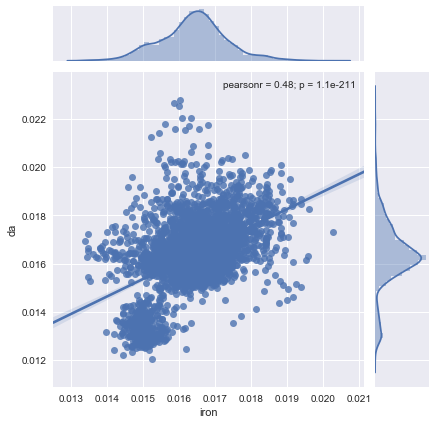

In [26]:
plot(df, 'iron','da')

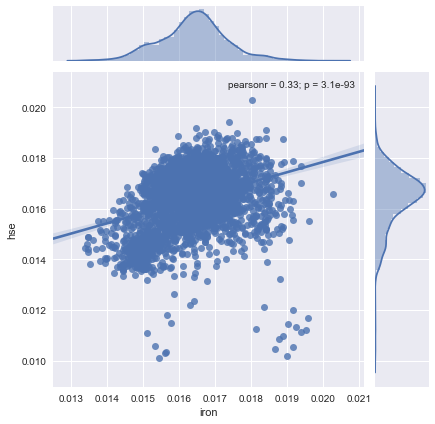

In [27]:
plot(df, 'iron','hse')